# BC2- Predicting Cancellations 

In [1]:
import flask
import pickle

In [2]:
import os
from pathlib import Path
from math import ceil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from pandas_profiling import ProfileReport




from joblib import dump

from sklearn.preprocessing import LabelEncoder,MinMaxScaler, StandardScaler,OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import classification_report, confusion_matrix, precision_score
from sklearn.neighbors import LocalOutlierFactor
from sklearn.neural_network import MLPClassifier




import graphviz
import imblearn

import warnings
warnings.filterwarnings('ignore')

# Defining PROJECT_ROOT
PROJECT_ROOT = Path(os.path.abspath('')).resolve().parents[0]

In [3]:
from pandas import set_option
from pandas.plotting import scatter_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import svm




In [4]:
import matplotlib.pyplot as plt 
from mlxtend.plotting import plot_confusion_matrix 
from mlxtend.classifier import StackingClassifier 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.naive_bayes import GaussianNB  
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score

In [5]:
df = pd.read_csv('H2.csv')

In [6]:
df.shape

(79330, 31)

### Cleaning

In [7]:
df.drop(['Country'], axis=1,inplace = True)
# Since you dont have this information prior to the check-in

df.drop(['IsCanceled'], axis=1,inplace = True)
#Since we will try to predict also the not show clients

df.drop(['DepositType'], axis=1, inplace = True)

df.drop(columns = ['ArrivalDateYear','ArrivalDateMonth','ArrivalDateDayOfMonth','ArrivalDateWeekNumber'], axis=1, inplace = True)


In [8]:
#Cleaning the target variable
df['ReservationStatus'] =df['ReservationStatus'].astype('category').cat.codes

df['ReservationStatus'].value_counts()

1    46228
0    32186
2      916
Name: ReservationStatus, dtype: int64

### Check continuos correlations 

In [9]:

cor = df[['ReservationStatus','LeadTime','StaysInWeekendNights','StaysInWeekNights',
          'Adults','Children','Babies','PreviousCancellations',
          'PreviousBookingsNotCanceled','BookingChanges','DaysInWaitingList','ADR',
         'RequiredCarParkingSpaces','TotalOfSpecialRequests']].corr()


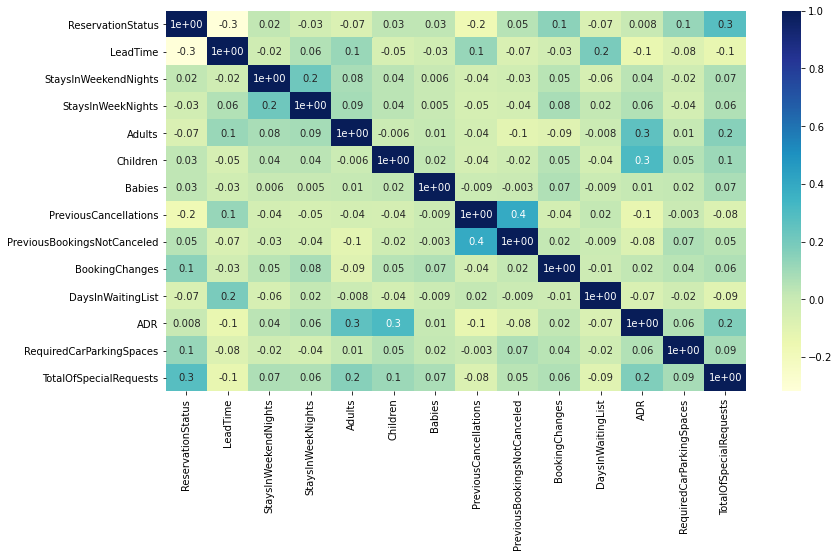

In [10]:
def cor_heatmap(cor):
    plt.figure(figsize=(13,7))
    sns.heatmap(data = cor, annot = True, cmap = 'YlGnBu', fmt = '.1')
    plt.show
    

cor_heatmap(cor)

### Check categorical correlation 

In [85]:
#ax = sns.countplot(x="MarketSegment", hue="ReservationStatus", data=df[df['MarketSegment']=='Groups'] )



In [14]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
LeadTime,79330.0,109.735724,110.948526,0.0,23.0,74.0,163.0,629.0
StaysInWeekendNights,79330.0,0.795185,0.885026,0.0,0.0,1.0,2.0,16.0
StaysInWeekNights,79330.0,2.182957,1.456416,0.0,1.0,2.0,3.0,41.0
Adults,79330.0,1.850977,0.509292,0.0,2.0,2.0,2.0,4.0
Children,79326.0,0.091370,0.372177,0.0,0.0,0.0,0.0,3.0
Babies,79330.0,0.004941,0.084323,0.0,0.0,0.0,0.0,10.0
IsRepeatedGuest,79330.0,0.025615,0.157983,0.0,0.0,0.0,0.0,1.0
PreviousCancellations,79330.0,0.079743,0.415472,0.0,0.0,0.0,0.0,21.0
PreviousBookingsNotCanceled,79330.0,0.132371,1.693411,0.0,0.0,0.0,0.0,72.0
BookingChanges,79330.0,0.187369,0.608620,0.0,0.0,0.0,0.0,21.0


In [15]:
df.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
LeadTime,79330,NaN,NaN,NaN,109.736,110.949,0,23,74,163,629
StaysInWeekendNights,79330,NaN,NaN,NaN,0.795185,0.885026,0,0,1,2,16
StaysInWeekNights,79330,NaN,NaN,NaN,2.18296,1.45642,0,1,2,3,41
Adults,79330,NaN,NaN,NaN,1.85098,0.509292,0,2,2,2,4
Children,79326,NaN,NaN,NaN,0.0913698,0.372177,0,0,0,0,3
Babies,79330,NaN,NaN,NaN,0.00494138,0.0843233,0,0,0,0,10
Meal,79330,4,BB,62305,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MarketSegment,79330,8,Online TA,38748,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DistributionChannel,79330,5,TA/TO,68945,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IsRepeatedGuest,79330,NaN,NaN,NaN,0.0256145,0.157983,0,0,0,0,1


# Outlier removal

In [16]:
#fill missing data in Children
df['Children'].fillna(df['Children'].median(), inplace=True)
df['Children'] = df['Children'].astype(int)

In [17]:
non_metric_features= ['AssignedRoomType','CustomerType',
                      'DistributionChannel','IsRepeatedGuest','MarketSegment','Meal',
                      'ReservationStatusDate','ReservedRoomType','Agent','Company']
metric_features = df.columns.drop(non_metric_features)

### Spliting the data

In [18]:
X = df.drop(columns = ['ReservationStatus'])
y = df[['ReservationStatus']]



In [19]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=15
                                                    , stratify=y)

combine = [X_train,X_test]

### Numerical
- Lead time- nao apagar
- StaysInWeekendNights - apagar o 14
- StaysInWeekNights - apagar o 24
- Adults - nao apagar
- Children - nao apagar
- Babies - apagar o 10
- PreviousCancellations - apagar no 10
- PreviousBookingsNotCanceled - apagar no 34
- BookingChanges - apagar no 12
- DaysInWaitingList - apagar no 260
- ADR - apagar no 400 
- RequiredCarParkingSpaces - Nao apagar
- TotalOfSpecialRequests - Nao apagar

**13 numerical variables**

In [20]:
# hist = px.histogram(X_train, x=X_train['LeadTime'], color_discrete_sequence=['darkseagreen'], template='plotly_white')
# hist.show()

In [21]:
Xy = pd.concat([X_train, y_train], axis=1)

In [22]:
lof = LocalOutlierFactor(n_neighbors=20, contamination = 0.03)
result=lof.fit_predict(Xy[metric_features])

In [23]:
outliers_index= np.where(result==-1)
outliers_index=outliers_index[0]


In [24]:
metric_features_1 = Xy[metric_features].drop(Xy[metric_features].index[outliers_index],axis=0)

df_2 = Xy.drop(Xy.index[outliers_index],axis=0)



In [25]:
print('Percentage of data kept after removing outliers:'
      , np.round(metric_features_1.shape[0] /Xy[metric_features].shape[0], 4))

Percentage of data kept after removing outliers: 0.97


In [26]:
Xy = df_2

In [27]:
X_train = Xy.iloc[:,:-1]
y_train = Xy.iloc[:,-1]

### Categorical

Eu acho que nestas temos de ver é como é que reduzimos o numero de categorias

- ArrivalDateYear - Nao apagar
- ArrivalDateMonth - Nao apagar
- ArrivalDateWeekNumber - Nao apagar
- ArrivalDateDayOfMonth - Nao apagar
- Meal - Nao apagar / FB
- MarketSegment - Undefined
- DistributionChannel - Undefined and GDS
- IsRepeatedGuest - variavel binária
- ReservedRoomType - Juntar as categorias
- AssignedRoomType - Igual ao de cima
- Agent - Nao apagar
- Company - Nao apagar
- CustomerType - Nao apagar

**13 categorical**

In [28]:
# hist = px.histogram(X_train, x=X_train['Agent'], color_discrete_sequence=['darkseagreen'], template='plotly_white')
# hist.show()

In [29]:
#ax = sns.countplot(x="Meal", hue="ReservationStatus", data=X_train)


0 - cancelar
1 - check out
2 - no show

# Feature Engineering

In [30]:
combine = [X_train,X_test]

In [31]:
 months = {
            'January' : 1,
            'February' : 2,
            'March' : 3,
            'April' : 4,
            'May' : 5,
            'June' : 6,
            'July' : 7,
            'August' : 8,
            'September' : 9, 
            'October' : 10,
            'November' : 11,
            'December' : 12
    }

In [32]:
# for dataset in combine:
#     dataset['ArrivalDateMonth'] = dataset['ArrivalDateMonth'].map(months)

In [33]:
for dataset in combine:
    dataset["Meal"] = dataset["Meal"].map({"BB       ":'BB',"SC       ":'SC','FB       ':'HB/FB', 'HB       ':'HB/FB'})




In [34]:
for dataset in combine:
    dataset['MarketSegment'] = np.where(dataset['MarketSegment'] == 'Undefined','Other', dataset['MarketSegment'])
    dataset['MarketSegment'] = np.where(dataset['MarketSegment'] == 'Aviation','Other', dataset['MarketSegment']) 
    dataset['MarketSegment'] = np.where(dataset['MarketSegment'] == 'Complementary','Other', dataset['MarketSegment']) 



    

In [35]:
for dataset in combine:
    dataset['DistributionChannel'] = np.where(dataset['DistributionChannel'] == 'Undefined','Other', dataset['DistributionChannel'])
    dataset['DistributionChannel'] = np.where(dataset['DistributionChannel'] == 'GDS','Other', dataset['DistributionChannel']) 



In [36]:
for dataset in combine:
    dataset['Agent'] = np.where(dataset['Agent'] != '       NULL','1', dataset['Agent'])
    dataset['Agent'] = np.where(dataset['Agent'] == '       NULL','0', dataset['Agent'])





In [37]:
for dataset in combine:
    dataset['Company'] = np.where(dataset['Company'] != '       NULL','1', dataset['Company'])
    dataset['Company'] = np.where(dataset['Company'] == '       NULL','0', dataset['Company'])



In [38]:
for dataset in combine:
    dataset['Nr People'] = dataset['Adults'] + dataset['Children'] + dataset['Babies']



In [39]:
for dataset in combine:
    X_train['Totalnights']= X_train.StaysInWeekNights + X_train.StaysInWeekendNights
    X_test['Totalnights']= X_test.StaysInWeekNights + X_test.StaysInWeekendNights

# Normalization

In [40]:
metric_features = ['LeadTime', 'StaysInWeekendNights', 'StaysInWeekNights', 'Adults',
       'Children', 'Babies', 'PreviousCancellations',
       'PreviousBookingsNotCanceled', 'BookingChanges', 'DaysInWaitingList',
       'ADR', 'RequiredCarParkingSpaces', 'TotalOfSpecialRequests']

In [41]:
# scaler1 = StandardScaler()
# scaled_feat_X_train = scaler1.fit_transform(X_train[metric_features])
# X_train_scaled = pd.DataFrame(scaled_feat_X_train, columns =X_train[metric_features].columns )



In [42]:
# scaler2 = StandardScaler()
# scaled_feat_X_test = scaler2.fit_transform(X_test[metric_features])
# X_test_scaled = pd.DataFrame(scaled_feat_X_test, columns =X_test[metric_features].columns )



# Feature Enconding

In [43]:
# One hot encode categorical features
ohc_features = [#'ArrivalDateYear', 'ArrivalDateMonth', 'ArrivalDateWeekNumber', 'ArrivalDateDayOfMonth'
                'Meal', 
                'MarketSegment', 'DistributionChannel','IsRepeatedGuest','ReservedRoomType','AssignedRoomType',
               'Agent','Company','CustomerType']

ohc = OneHotEncoder(sparse=False, drop= 'first')
df_ohc_train = pd.DataFrame(ohc.fit_transform(X_train[ohc_features]),
index=X_train.index,
columns=ohc.get_feature_names(ohc_features))
#X_train  = pd.concat([X_train,df_ohc_train],axis = 1)

In [44]:
ohc = OneHotEncoder(sparse=False,drop= 'first' )
df_ohc_test = pd.DataFrame(ohc.fit_transform(X_test[ohc_features]),
index=X_test.index,
columns=ohc.get_feature_names(ohc_features))
#X_test  = pd.concat([X_test,df_ohc_test],axis = 1)

In [45]:
X_train.reset_index(inplace = True, drop = True)
X_test.reset_index(inplace = True, drop = True)
df_ohc_test.reset_index(inplace = True, drop = True)
df_ohc_train.reset_index(inplace = True, drop = True)



In [46]:
# X_train[metric_features] = X_train_scaled
# X_test[metric_features] = X_test_scaled

In [47]:
X_train  = pd.concat([X_train,df_ohc_train],axis = 1)
X_test  = pd.concat([X_test,df_ohc_test],axis = 1)

In [48]:
X_train.drop(columns = ohc_features,inplace = True)
X_test.drop(columns = ohc_features,inplace = True)

X_test.drop('ReservationStatusDate',axis = 1, inplace = True)
X_train.drop('ReservationStatusDate',axis = 1, inplace = True)





# Model Selection

In [49]:
# # Spot-Check Algorithms
# def GetBasedModel():
#     basedModels = []
#     basedModels.append(('LR'   , LogisticRegression())) 
#     basedModels.append(('LDA'  , LinearDiscriminantAnalysis()))
#     basedModels.append(('KNN'  , KNeighborsClassifier()))
#     basedModels.append(('CART' , DecisionTreeClassifier()))
#     basedModels.append(('NB'   , GaussianNB()))
#     basedModels.append(('AB'   , AdaBoostClassifier()))
#     basedModels.append(('GBM'  , GradientBoostingClassifier()))
#     basedModels.append(('RF'   , RandomForestClassifier()))
#     basedModels.append(('ET'   , ExtraTreesClassifier()))

    
#     return basedModels

In [50]:
# def BasedLine2(X_train, y_train,models):
#     # Test options and evaluation metric
#     num_folds = 10
#     scoring = 'accuracy'

#     results = []
#     names = []
#     for name, model in models:
#         kfold = StratifiedKFold(n_splits=num_folds, random_state=SEED)
#         cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
#         results.append(cv_results)
#         names.append(name)
#         msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
#         print(msg)
        
#     return names, results

In [51]:
# class PlotBoxR(object):
    
    
#     def __Trace(self,nameOfFeature,value): 
    
#         trace = go.Box(
#             y=value,
#             name = nameOfFeature,
#             marker = dict(
#                 color = 'rgb(0, 128, 128)',
#             )
#         )
#         return trace

#     def PlotResult(self,names,results):
        
#         data = []

#         for i in range(len(names)):
#             data.append(self.__Trace(names[i],results[i]))


#         py.iplot(data)

In [52]:
# SEED = 7
# np.random.seed(SEED)

In [53]:
# models = GetBasedModel()
# names,results = BasedLine2(X_train, y_train,models)
# #PlotBoxR().PlotResult(names,results)

### Model Finetuning

In [54]:
# # Define the Random Forest model
# rf = RandomForestClassifier(random_state=0,class_weight='auto')

# # Define the grid to explore
# grid = {
#     "criterion": ["entropy", "gini"],
#     "max_depth": [3, 6, 9],
#     "min_samples_split": [0.005, 0.01, 0.05],
#     "max_features": [None, "sqrt"],
#     "class_weight": [None, 'balanced', {0: 1, 1: 2}]
#     }

In [55]:
# # Instatiating GridSearch
# splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
# gscv = GridSearchCV(rf, grid, cv=splitter, scoring='f1_weighted', refit=True, verbose=-1, n_jobs=-1)

# # Get ID of grid search
# # id_num = input("Insert GridSearch ID number: ")
# id_num = 1

In [56]:
# # Grid Search and model training
# #gscv.fit(X_train, y_train)

# # Saving cv_results for specific Grid Search run
# #out_path = os.path.join(PROJECT_ROOT, 'analysis')
# #score_summary = pd.DataFrame(gscv.cv_results_).sort_values(by="mean_test_score", ascending=False)
# #score_summary.to_csv(os.path.join(out_path, 'grid_search_results{}.csv'.format(id_num)))

# # Saving best model
# best_rf = gscv.best_estimator_
# dump(best_rf, os.path.join(out_path, 'best_random_forest{}.joblib'.format(id_num)))

# # Get test set y_pred and evaluate on precision
# y_test_pred = best_rf.predict(X_test)

# print("The best model has a mean cross-validated precision of {0:.3f} and a test set precision of {1:.3f}".\
#       format(gscv.best_score_, precision_score(y_test, y_test_pred,average = 'micro')))
# print("\nThe hyper-parameters selected are:\n", gscv.best_params_)

In [57]:
# print("The best model has a mean cross-validated precision of {0:.3f} and a test set precision of {1:.3f}".\
#       format(gscv.best_score_, precision_score(y_test, y_test_pred,average = 'micro')))
# print("\nThe hyper-parameters selected are:\n", gscv.best_params_)

# Feature Selection

In [58]:
X_train= X_train[['LeadTime', 'StaysInWeekendNights', 'StaysInWeekNights', 'Adults',
       'Children', 'Babies', 'PreviousCancellations',
       'PreviousBookingsNotCanceled', 'BookingChanges', 'DaysInWaitingList',
       'ADR', 'RequiredCarParkingSpaces', 'TotalOfSpecialRequests',
       'Nr People', 'Totalnights', 'Meal_HB/FB', 'Meal_SC',
       'MarketSegment_Direct', 'MarketSegment_Groups',
       'MarketSegment_Offline TA/TO', 'MarketSegment_Online TA',
       'MarketSegment_Other', 'DistributionChannel_Direct',
       'DistributionChannel_Other', 'DistributionChannel_TA/TO',
       'IsRepeatedGuest_1','Agent_1', 'Company_1',
       'CustomerType_Group', 'CustomerType_Transient',
       'CustomerType_Transient-Party']]

In [59]:
X_test= X_test[['LeadTime', 'StaysInWeekendNights', 'StaysInWeekNights', 'Adults',
       'Children', 'Babies', 'PreviousCancellations',
       'PreviousBookingsNotCanceled', 'BookingChanges', 'DaysInWaitingList',
       'ADR', 'RequiredCarParkingSpaces', 'TotalOfSpecialRequests',
       'Nr People', 'Totalnights', 'Meal_HB/FB', 'Meal_SC',
       'MarketSegment_Direct', 'MarketSegment_Groups',
       'MarketSegment_Offline TA/TO', 'MarketSegment_Online TA',
       'MarketSegment_Other', 'DistributionChannel_Direct',
       'DistributionChannel_Other', 'DistributionChannel_TA/TO',
       'IsRepeatedGuest_1','Agent_1', 'Company_1',
       'CustomerType_Group', 'CustomerType_Transient',
       'CustomerType_Transient-Party']]

### Oversampling the train dataset

In [60]:
y_train.value_counts()

1    36124
0    24719
2      717
Name: ReservationStatus, dtype: int64

In [61]:
# sampling = {0:36124,
#             1:36124,
#             2:9000
# }

In [62]:
# from imblearn.over_sampling import SMOTE

# smote = SMOTE(sampling_strategy=sampling, k_neighbors = 5)
# X_sm, y_sm = smote.fit_sample(X_train, y_train)

# X_train = X_sm
# y_train = y_sm

In [63]:
# y_train.value_counts()

In [64]:
# y_test['ReservationStatus'].value_counts()

### Build and assess model

In [65]:
rf = RandomForestClassifier(criterion='entropy', max_depth=200, max_features=None,
                       min_samples_split=0.005, random_state=0)
rf.fit(X_train, y_train)
RF_score = rf.score(X_test,y_test)
RF_score

0.8211899659649565

In [66]:
RF_score = rf.score(X_train,y_train)
RF_score


0.8214262508122158

In [67]:
# Get test set y_pred and evaluate on precision
y_test_pred = rf.predict(X_test)

### Model evaluation

In [68]:
# Test set classification report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.85      0.71      0.77      6437
           1       0.81      0.91      0.86      9246
           2       0.00      0.00      0.00       183

    accuracy                           0.82     15866
   macro avg       0.55      0.54      0.54     15866
weighted avg       0.81      0.82      0.81     15866



In [69]:
# Test set confusion matrix
pd.DataFrame(data=confusion_matrix(y_test, y_test_pred), 
             index=pd.Index(y_train.unique(), name="True"), 
             columns=pd.Index(y_train.unique(), name="Pred"))

Pred,1,0,2
True,,,
1,4597,1840,0
0,814,8432,0
2,27,156,0


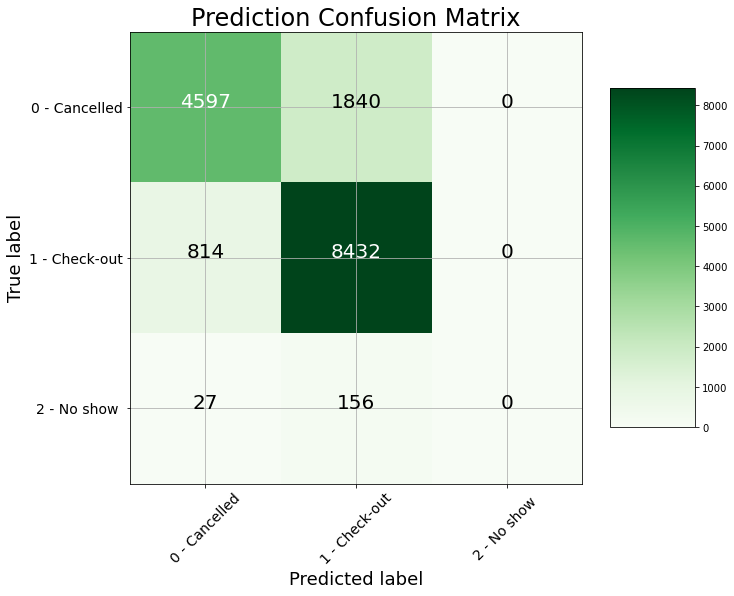

In [70]:
# plot confusion matrix
import itertools
 
def plot_confusion_matrix(cm, classes, normalize = False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens): # can change color 
    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    # Label the plot
    for i, j in itertools.product(range(cm.shape[0]),   range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), 
             fontsize = 20,
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)
    
    

cm = confusion_matrix(y_test, y_test_pred)
plot_confusion_matrix(cm, classes = ['0 - Cancelled', '1 - Check-out', '2 - No show '],
                      title = 'Prediction Confusion Matrix')

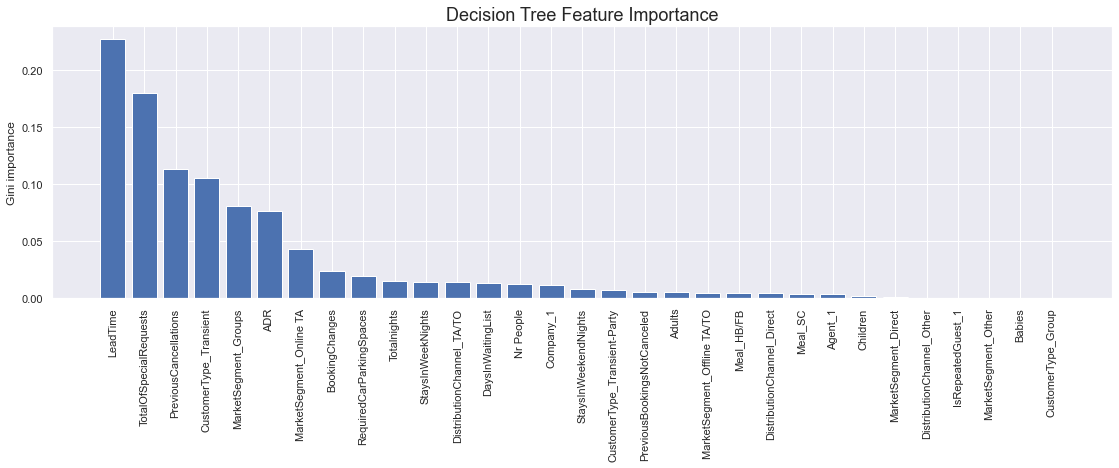

In [71]:
# Decision Tree Feature Importance plot
sns.set()

# data
feature_names = X_train.columns
feature_importances = pd.Series(rf.feature_importances_, index=feature_names).\
    sort_values(ascending=False)

# figure
fig = plt.figure(figsize=(19,5))

# axis
plt.bar(x=feature_importances.index, height=feature_importances.values)

# properties
plt.ylabel("Gini importance")  # The importance of a feature is computed as the (normalized) total reduction of the 
                               # criterion brought by that feature. It is also known as the Gini importance.
plt.xticks(rotation=90)
plt.title("Decision Tree Feature Importance", fontsize=18)

plt.show()

In [72]:
import pickle
pickl = {'model': rf}
pickle.dump( pickl, open( 'model_file' + ".p", "wb" ) )